In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## start comparaison 
## on va comparer le DNN avec un RF

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

## end comparaison


import tensorflow as tf
from keras.layers import Dense,InputLayer
from keras.datasets import mnist, fashion_mnist


In [2]:
random_state = 42

tf.random.set_seed(
    random_state
)

"""https://github.com/ashishpatel26/Tools-to-Design-or-Visualize-Architecture-of-Neural-Network"""

# utilities

In [3]:
## plot and evaluate model

def plot_cm_display(y_true: np.array, y_pred: np.array) -> None:
    cm = confusion_matrix(y_true, y_pred)
    
    #plt.figure(figsize=(20, 8))
    #plt.title('Confusion Matrix\n')
    CM = ConfusionMatrixDisplay(cm)
    CM.plot()
    #sns.heatmap(cm, cmap='vlag', annot=True, fmt='d', cbar=False)
    plt.xlabel('y_pred')
    plt.ylabel('y_true')
    plt.show()


def plot_lc(history: dict, metrics: list = ['loss', 'accuracy']) -> None:
    plt.figure(figsize=(20, 8))
    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i+1)
        plt.title(f'Learning curve for {metric}\n')
        plt.plot(history[metric], label='train')
        plt.plot(history[f'val_{metric}'], label='val')
        plt.xlabel('epochs')
        plt.ylabel(metric)
        plt.legend()
        if metric == 'accuracy':
            plt.ylim(0,1.1)
    plt.show()



# Data

In [4]:
### integrated data "mnist" from tensorflow
### only use this method for library-integrated data
(X_train, y_train), (X_test, y_test) = mnist.load_data()


In [5]:
#60k imgs with 28 pixels by 28 pixels
X_train.shape

(60000, 28, 28)

# EDA


## format

In [6]:
type(X_train)

numpy.ndarray

In [7]:
X_train.shape ### 60_000 lignes/number of images, 28x28 pixels

(60000, 28, 28)

In [8]:
X_train.dtype # unsigned integer 0->255

dtype('uint8')

In [9]:
np.sum(np.isnan(X_train),axis=None)

np.int64(0)

## univariate-target

y_train
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: count, dtype: int64

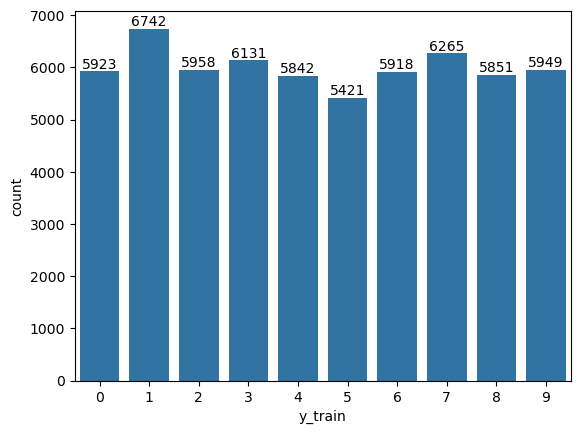

In [10]:
y_series = pd.Series(data=y_train, name='y_train')
GB_y = y_series.value_counts().sort_index()
display(GB_y)

ax = sns.barplot(x=GB_y.index,y=GB_y)
for c in ax.containers:
    ax.bar_label(c)
plt.show()


## univariate-features

In [11]:
print('max=',np.max(X_train,axis=None))
print('min=',np.min(X_train,axis=None))
print('mean=',np.mean(X_train,axis=None))
print('std=',np.std(X_train,axis=None))

max= 255
min= 0
mean= 33.318421449829934
std= 78.56748998339798


## distribution of images

### examples

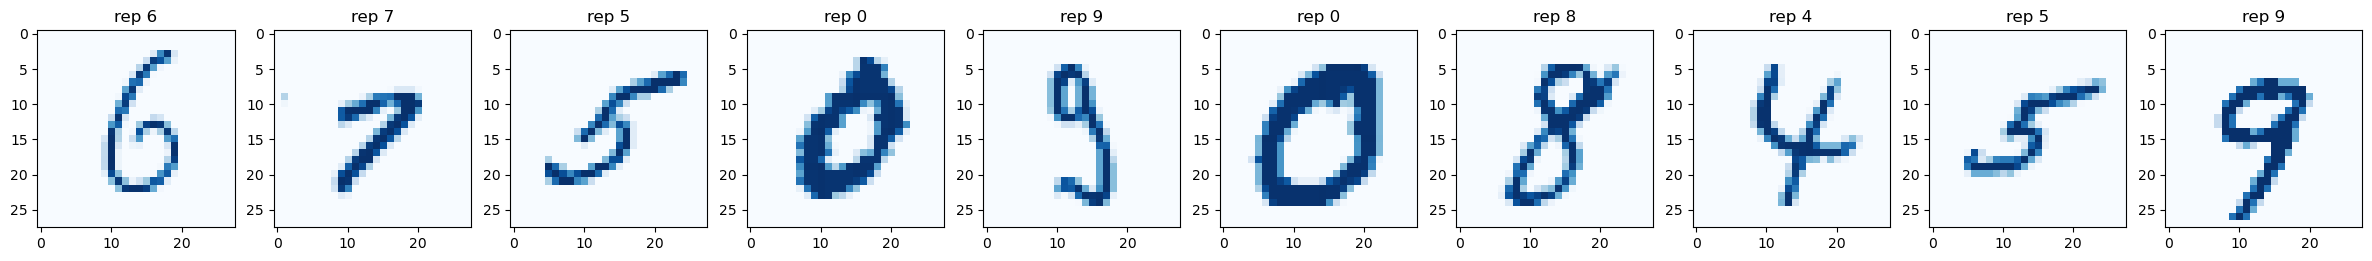

In [12]:
N = 10
lst_rdm = np.unique(np.random.randint(1,200,N))

plt.figure(figsize=(3*N,5))
for n,idx in enumerate(lst_rdm):
    plt.subplot(1,N,n+1)
    plt.imshow(X_train[idx], cmap='Blues')
    plt.title(f'rep {y_train[idx]}')

plt.show()

## global distribution

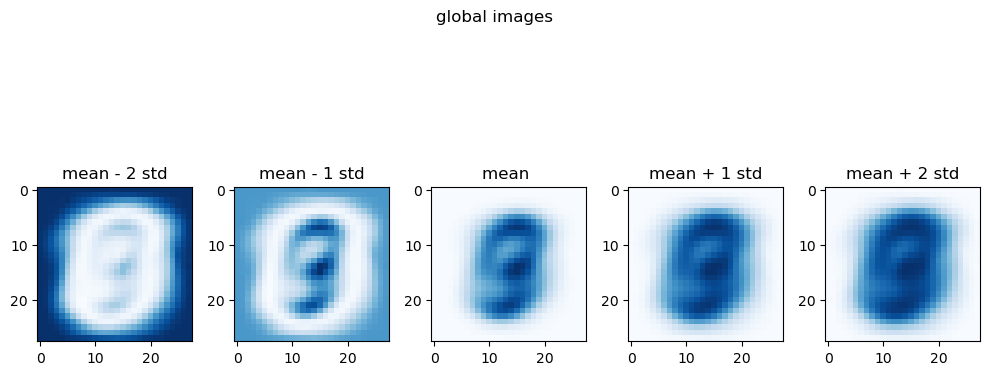

In [13]:
glob_avg_img = np.mean(X_train,axis=0) ## image moyenne
glob_std_img = np.std(X_train,axis=0) ## std d'image

plt.figure(figsize=(10,5))
plt.subplot(1,5,1)
plt.imshow(glob_avg_img-2*glob_std_img,cmap='Blues')
plt.title(f'mean - 2 std')

plt.subplot(1,5,2)
plt.imshow(glob_avg_img-1*glob_std_img,cmap='Blues')
plt.title(f'mean - 1 std')

plt.subplot(1,5,3)
plt.imshow(glob_avg_img ,cmap='Blues')
plt.title(f'mean ')

plt.subplot(1,5,4)
plt.imshow(glob_avg_img+1*glob_std_img,cmap='Blues')
plt.title(f'mean + 1 std')

plt.subplot(1,5,5)
plt.imshow(glob_avg_img+2*glob_std_img,cmap='Blues')
plt.title(f'mean + 2 std')

plt.suptitle('global images')
plt.tight_layout()
plt.show()

## bivariate image distribution

------------------------------
y=0
max= 255
min= 0
mean= 44.21682790539819
std= 88.66807293975513
------------------------------


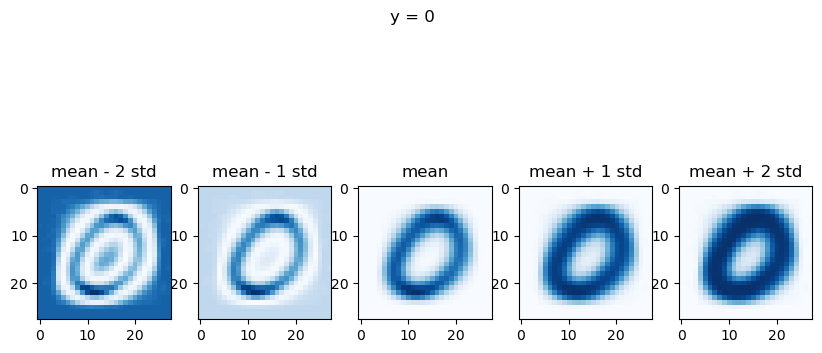

------------------------------
y=1
max= 255
min= 0
mean= 19.379653852790003
std= 62.29178755571119
------------------------------


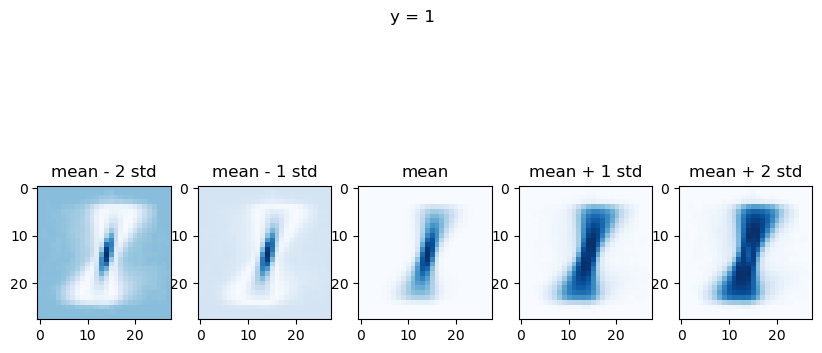

------------------------------
y=2
max= 255
min= 0
mean= 37.98865784984689
std= 83.11048388578874
------------------------------


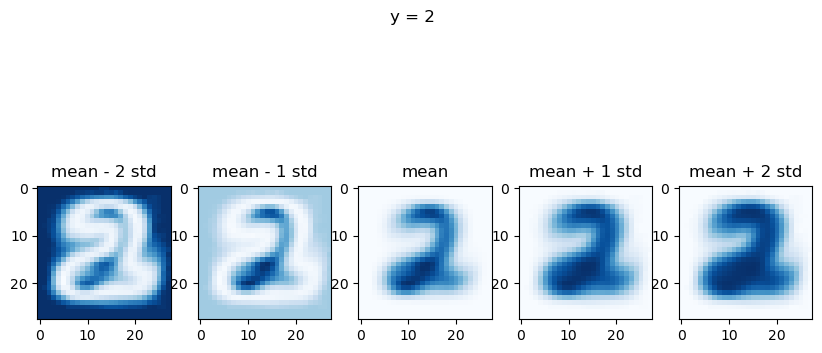

------------------------------
y=3
max= 255
min= 0
mean= 36.09018653946654
std= 81.0692353756164
------------------------------


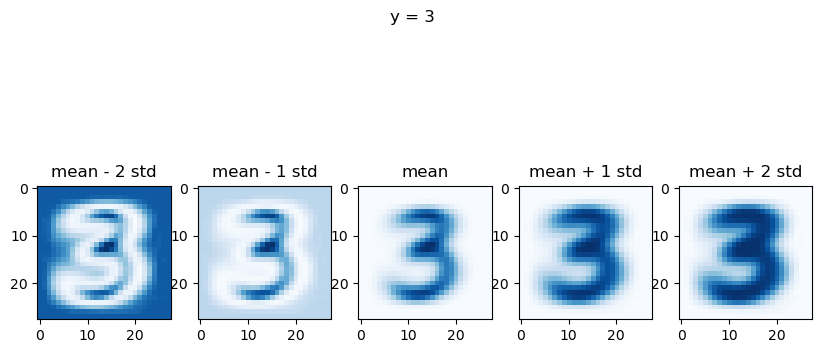

------------------------------
y=4
max= 255
min= 0
mean= 30.94822568277568
std= 75.85848996400738
------------------------------


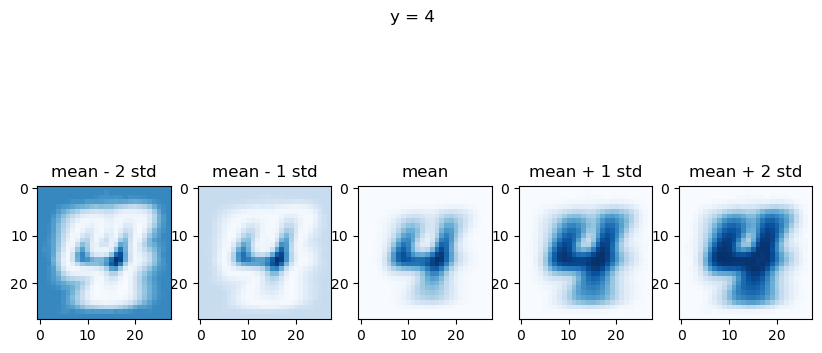

------------------------------
y=5
max= 255
min= 0
mean= 32.83109548467976
std= 77.41506624626122
------------------------------


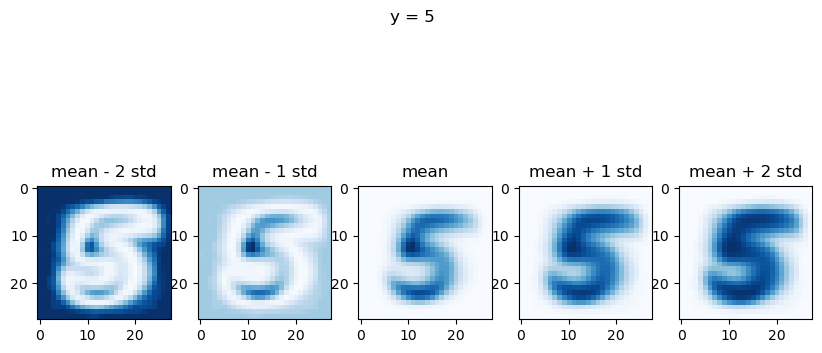

------------------------------
y=6
max= 255
min= 0
mean= 35.01195268154575
std= 80.29885348978507
------------------------------


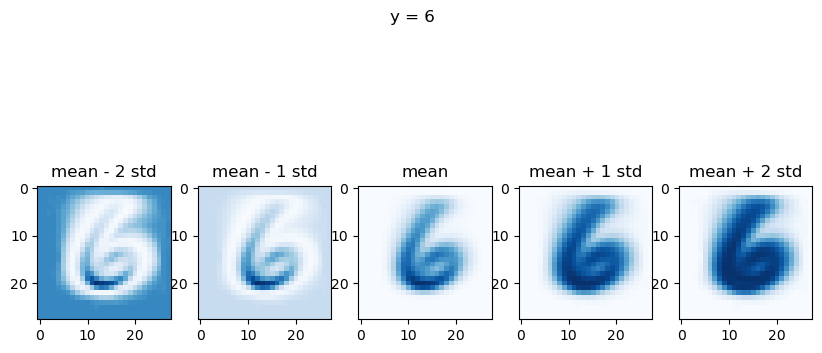

------------------------------
y=7
max= 255
min= 0
mean= 29.204562926527355
std= 74.38243138303984
------------------------------


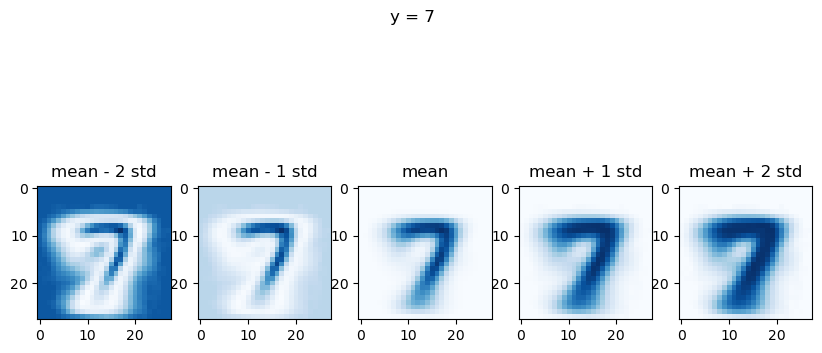

------------------------------
y=8
max= 255
min= 0
mean= 38.28977538289286
std= 82.9412885831376
------------------------------


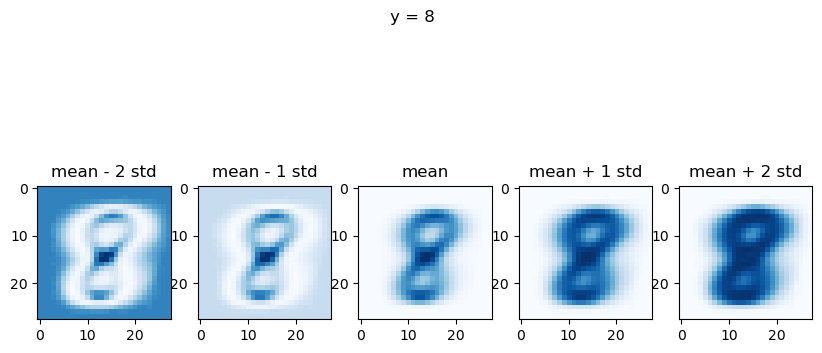

------------------------------
y=9
max= 255
min= 0
mean= 31.26043542732272
std= 76.15257205456176
------------------------------


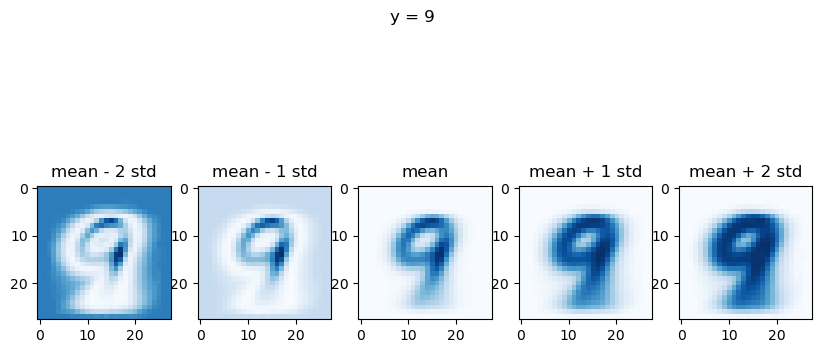

In [14]:
N_y = len(GB_y)

for n,y in enumerate(GB_y.index):
    
    plt.figure(figsize=(10,5))
    cond_y = y_train == y
    X_train_y = X_train[cond_y]
    print('-'*30)
    print(f'y={y}')
    print('max=',np.max(X_train_y,axis=None))
    print('min=',np.min(X_train_y,axis=None))
    print('mean=',np.mean(X_train_y,axis=None))
    print('std=',np.std(X_train_y,axis=None))
    print('-'*30)
    
    avg_img_y = np.mean(X_train_y ,axis=0)
    std_img_y = np.std(X_train_y  ,axis=0)

    plt.subplot(1, 5, 1)
    plt.imshow(avg_img_y-2*std_img_y,cmap='Blues')
    plt.title(f'mean - 2 std')
    
    plt.subplot(1, 5, 2)
    plt.imshow(avg_img_y-1*std_img_y,cmap='Blues')
    plt.title(f'mean - 1 std')
    
    plt.subplot(1, 5, 3)
    plt.imshow(avg_img_y ,cmap='Blues')
    plt.title(f'mean')
    
    plt.subplot(1, 5, 4)
    plt.imshow(avg_img_y+1*std_img_y,cmap='Blues')
    plt.title(f'mean + 1 std')
    
    plt.subplot(1, 5, 5)
    plt.imshow(avg_img_y+2*std_img_y,cmap='Blues')
    plt.title(f'mean + 2 std')

    plt.suptitle(f'y = {y}')
    plt.show()
    
    

# preprocessing

In [15]:
arr = np.arange(0,12)
display(arr)

#arr.reshape(1,12)
#arr.reshape(2,6)
try : 
    arr.reshape(3,3)
except:
    print('not possible')

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

not possible


In [16]:

### NN très sensible à l'echelle de grandeur ==> standardiser/normaliser entre 0 et 1 par convention
X_train = X_train/np.max(X_train,axis=None) ## diviser par 255
X_test = X_test/np.max(X_test,axis=None)

### Preprocessing pour le DNN
X_train_1 = X_train.reshape(60_000,28*28) ### init = (60_000, 28,28) -> new = (60_000,28*28) ## (-1,28*28) = ('flexible'/undefined/rest, 28*28) 
X_test_1 = X_test.reshape(-1,28*28)

In [17]:
28*28

784

# Models

In [18]:
def mymodel():

    ### PARAMETRES SPECIFIQUE AU DATA ###
    N_INPUT = (28*28,)
    N_OUTPUT = 10

    LOSS = "sparse_categorical_crossentropy"
    OUTPUT_ACTIVATION_FUNCTION = "softmax"
    
    ### PARAMETRES ARBITRAIRES ###
    ACTIVATION_FUNCTION = "tanh" ## tanh, sigmoid, relu, linear
    NUMBER_OF_NEURONS = 28
    
    model = tf.keras.models.Sequential([
        ### INPUT LAYER
        InputLayer(shape=N_INPUT, name="my_input_layer")
        
        ### START HIDDEN LAYER ###
        ,Dense(units=NUMBER_OF_NEURONS, activation=ACTIVATION_FUNCTION, name="my_first_dense_layer")
        ,Dense(units=NUMBER_OF_NEURONS, activation=ACTIVATION_FUNCTION,)
        ,Dense(units=10, activation="relu",)
        
        ### END HIDDEN LAYER
        
        ### OUTPUT LAYER
        ,Dense(units=N_OUTPUT, activation=OUTPUT_ACTIVATION_FUNCTION, name= "my_output_layer")
    ])
    
    model.compile(
            optimizer=tf.keras.optimizers.Adam() #'adam', ## use this by default
            ,loss=LOSS 
            ,metrics=['accuracy'] ### additional metrics to calculate
    )
    
    return model

In [19]:
model = mymodel() ## creer/re-init
model.fit(X_train_1, y_train, batch_size=64, validation_split=0.15, epochs=10 ) # entrainer
#model.fit(X_train_1, y_train, batch_size=64, validation_split=0.15, epochs=5 ) # continuer l'entrainement, 
                                                                               # mais historique d'entrainement précédent peut être perdu

Epoch 1/10
797/797 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8218 - loss: 0.6249 - val_accuracy: 0.9303 - val_loss: 0.2416
Epoch 2/10
797/797 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9372 - loss: 0.2203 - val_accuracy: 0.9520 - val_loss: 0.1700
Epoch 3/10
797/797 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9522 - loss: 0.1650 - val_accuracy: 0.9594 - val_loss: 0.1436
Epoch 4/10
797/797 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9601 - loss: 0.1358 - val_accuracy: 0.9612 - val_loss: 0.1322
Epoch 5/10
797/797 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9658 - loss: 0.1167 - val_accuracy: 0.9613 - val_loss: 0.1296
Epoch 6/10
797/797 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9699 - loss: 0.1031 - val_accuracy: 0.9606 - val_loss: 0.1280
Epoch 7/10
797/797 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9739 - loss: 0.0927 - val_accuracy: 0.9611 - val_loss: 0.1266
Epoch 8/10
797/797 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9759 - loss: 0.0843 - val_accuracy: 0.

In [20]:
model.summary() # résumé du modèle (nécéssite entrainement)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ my_first_dense_layer (Dense)         │ (None, 28)                  │          21,980 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 28)                  │             812 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             290 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ my_output_layer (Dense)              │ (None, 10)                  │             110 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,578 (271.79 KB)

 Trainable params: 23,192 (90.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,386 (181.20 KB)

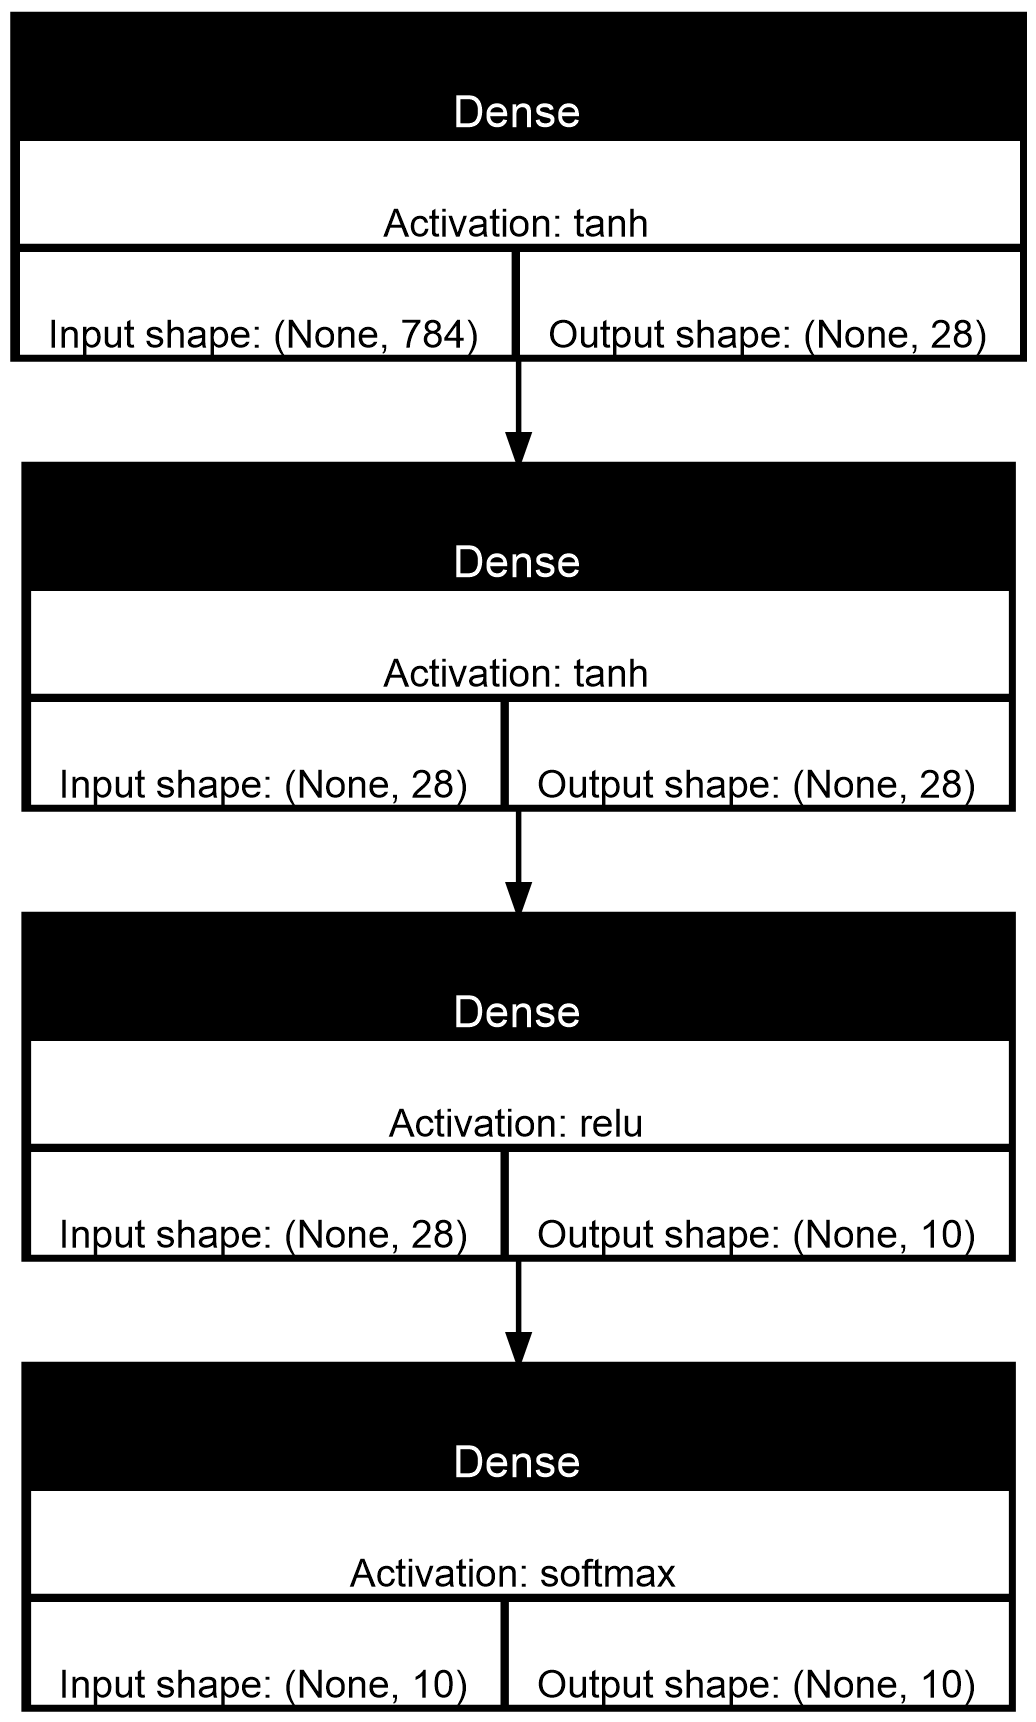

In [21]:
### anaconda : conda install pydot graphviz

tf.keras.utils.plot_model(
    model = model,
    show_layer_activations=True,
    show_shapes=True
)

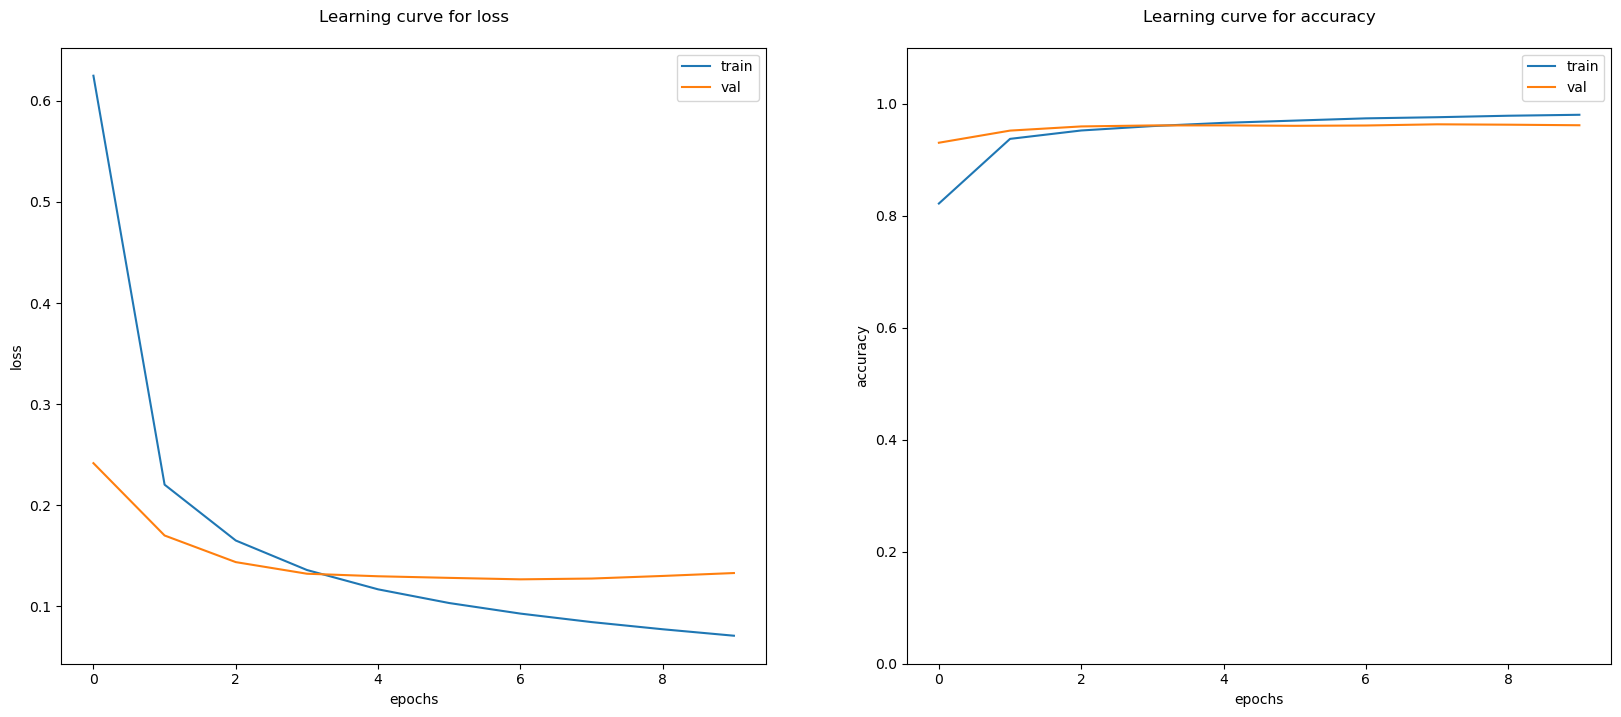

In [22]:
H = model.history.history

plot_lc(history=H)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


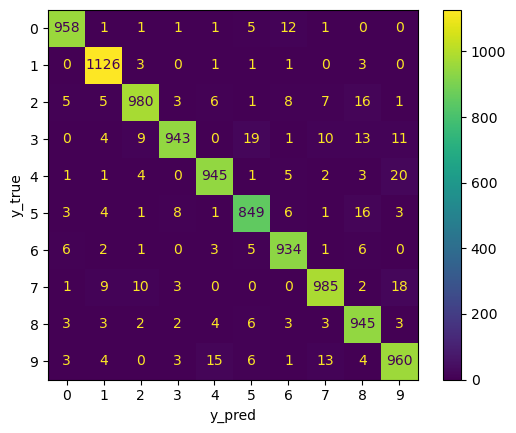

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.97      0.95      0.96      1032
           3       0.98      0.93      0.96      1010
           4       0.97      0.96      0.97       982
           5       0.95      0.95      0.95       892
           6       0.96      0.97      0.97       958
           7       0.96      0.96      0.96      1028
           8       0.94      0.97      0.95       974
           9       0.94      0.95      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [23]:
y_pred_range = model.predict(X_test_1)
y_pred = np.argmax(y_pred_range,axis=1)

plot_cm_display(y_true=y_test,y_pred=y_pred)
print(classification_report(y_true=y_test,y_pred=y_pred))

# comparaison avec PCA + RF

In [28]:
from sklearn.pipeline import make_pipeline

pca_rf = make_pipeline(PCA(n_components=115),RandomForestClassifier(n_estimators=21))

display(pca_rf)

,steps,"[('pca', ...), ('randomforestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_components,115
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10


In [29]:
param_grid_search = {'randomforestclassifier__max_depth':[5,20]}

grid = GridSearchCV(pca_rf, param_grid=param_grid_search,scoring='f1_macro', verbose=2)
grid.fit(X_train_1,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ................randomforestclassifier__max_depth=5; total time=  12.0s
[CV] END ................randomforestclassifier__max_depth=5; total time=  11.8s
[CV] END ................randomforestclassifier__max_depth=5; total time=  11.8s
[CV] END ................randomforestclassifier__max_depth=5; total time=  12.4s
[CV] END ................randomforestclassifier__max_depth=5; total time=  12.3s
[CV] END ...............randomforestclassifier__max_depth=20; total time=  26.4s
[CV] END ...............randomforestclassifier__max_depth=20; total time=  26.9s
[CV] END ...............randomforestclassifier__max_depth=20; total time=  27.4s
[CV] END ...............randomforestclassifier__max_depth=20; total time=  27.5s
[CV] END ...............randomforestclassifier__max_depth=20; total time=  28.0s


,estimator,Pipeline(step...imators=21))])
,param_grid,"{'randomforestclassifier__max_depth': [5, 20]}"
,scoring,'f1_macro'
,n_jobs,None
,refit,True
,cv,None
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_components,115


In [30]:
best = grid.best_estimator_

print(grid.best_score_)
display(best)

0.9252038595534511


,steps,"[('pca', ...), ('randomforestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_components,115
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10


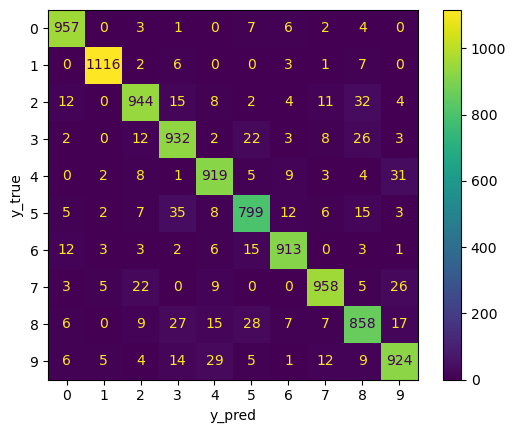

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.93      0.91      0.92      1032
           3       0.90      0.92      0.91      1010
           4       0.92      0.94      0.93       982
           5       0.90      0.90      0.90       892
           6       0.95      0.95      0.95       958
           7       0.95      0.93      0.94      1028
           8       0.89      0.88      0.89       974
           9       0.92      0.92      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [31]:
y_pred_best = best.predict(X_test_1)

plot_cm_display(y_true=y_test,y_pred=y_pred_best)

print(classification_report(y_true=y_test,y_pred=y_pred_best))